In [2]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'CLIENT_ID'
config.sh_client_secret  = 'CLIENT_SECRET'

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

c:\Users\casch\anaconda3\envs\geo_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from auxiliary_code.helper_functions import *
from shapely.geometry import Polygon
import geopandas as gpd

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

In [9]:
df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')
df_bbox = df_shape.bounds

In [10]:
polygon_geom = []
for bounds in df_bbox.to_numpy():
    polygon_geom.append(Polygon(zip(bounds[[0, 0, 2, 2, 0]], bounds[[1, 3, 3, 1, 1]])))

polygons = gpd.GeoDataFrame(index=range(len(polygon_geom)), geometry=polygon_geom)    

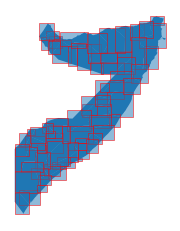

In [11]:
fig, ax = plt.subplots()
df_shape.plot(ax=ax)
polygons.plot(ax=ax, color=None, edgecolor="red", alpha=0.5)
ax.axis('off')

fig.savefig('../figures/bbox_bounds.pdf', format='pdf')

In [12]:
coords= list(df_bbox.iloc[0])
resolution = 120
betsiboka_bbox = BBox(bbox=coords, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 120 m resolution: (333, 190) pixels


In [13]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

In [14]:
year = 2020

start = datetime.datetime(year,1,1)
month = pd.DateOffset(months=1)
edges = [(start + month * i).date().isoformat() for i in range(13)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]

print('Monthly time windows:\n')
for slot in slots:
    print(slot)

Monthly time windows:

('2020-01-01', '2020-02-01')
('2020-02-01', '2020-03-01')
('2020-03-01', '2020-04-01')
('2020-04-01', '2020-05-01')
('2020-05-01', '2020-06-01')
('2020-06-01', '2020-07-01')
('2020-07-01', '2020-08-01')
('2020-08-01', '2020-09-01')
('2020-09-01', '2020-10-01')
('2020-10-01', '2020-11-01')
('2020-11-01', '2020-12-01')
('2020-12-01', '2021-01-01')


In [15]:
def get_request(time_interval, bbox, size):
    return SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=size,
        config=config
    )

In [1]:
path = f'E:/sentinel/{year}_new/'
resolution = 120

for idx, row in df_bbox.iterrows():
    bbox = BBox(bbox=list(row), crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=resolution)
    # create a list of requests
    list_of_requests = [get_request(slot, bbox, size) for slot in slots]
    list_of_requests = [request.download_list[0] for request in list_of_requests]
    # download data with multiple threads
    data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
    data = np.array(data)
    np.save(path + idx + '.npy')